### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [3]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


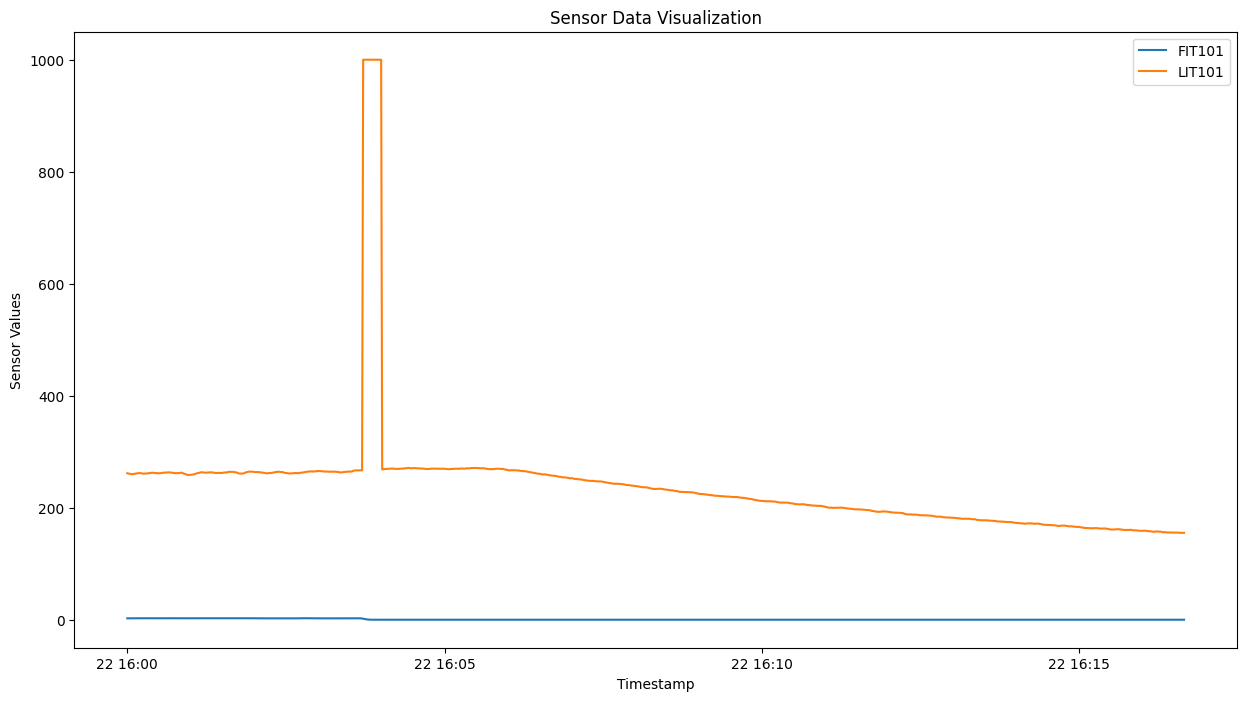

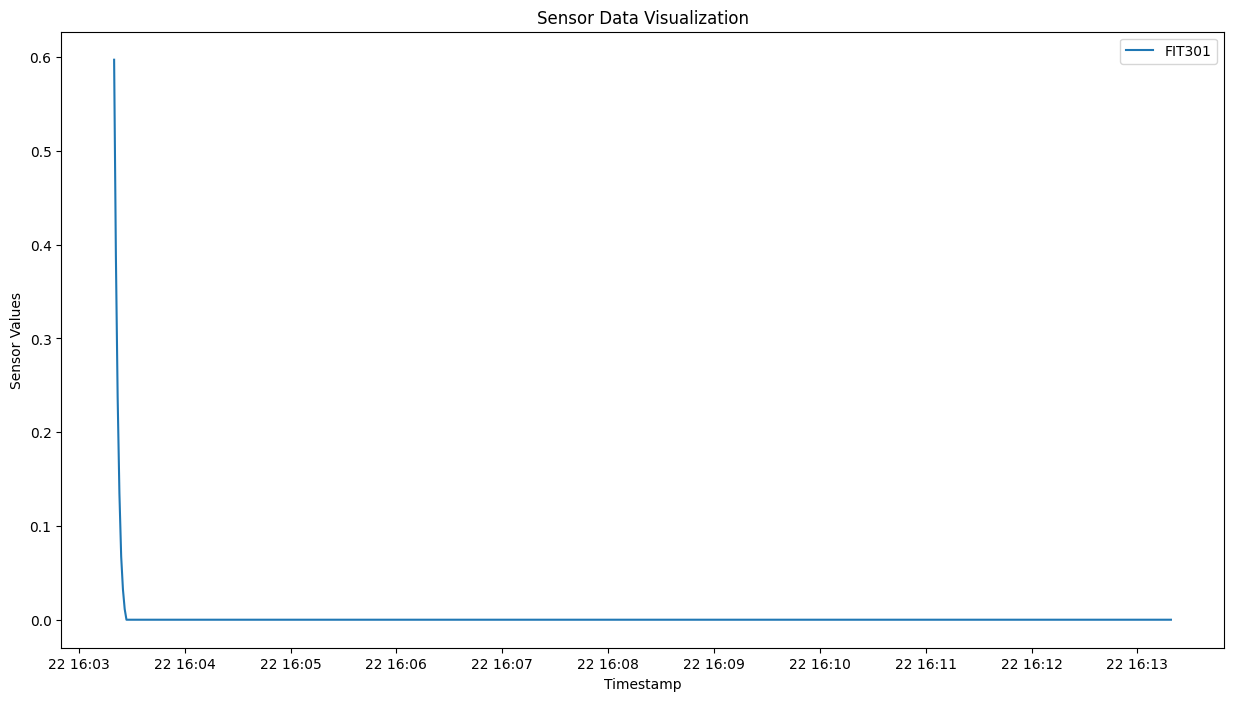

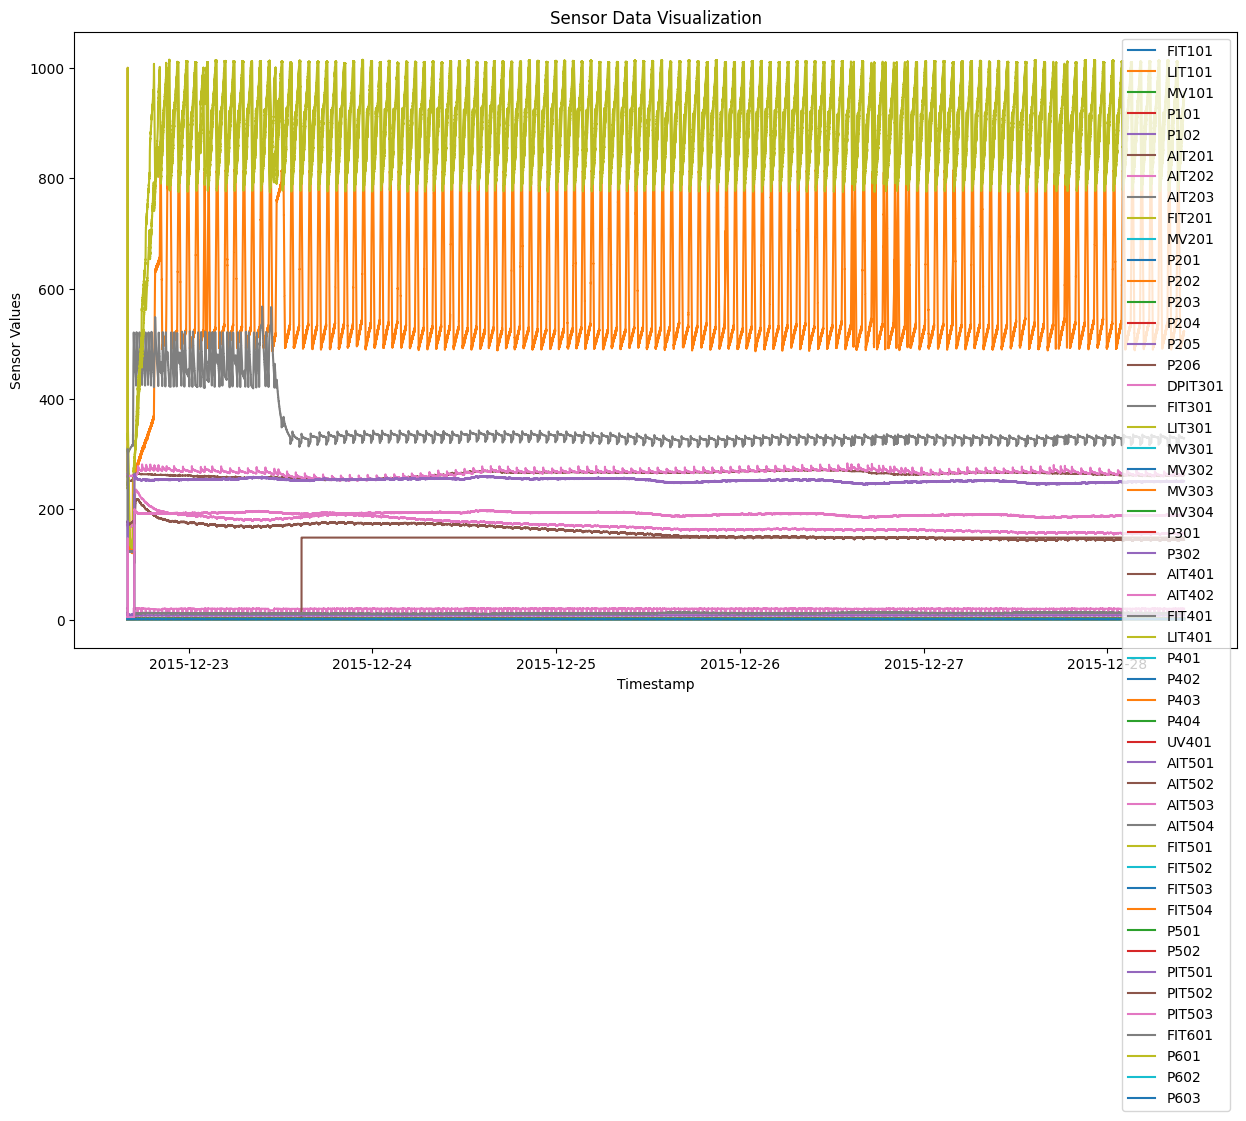

In [4]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)

### Familiarization

The first type of signal has a large variance (we can confirm this by looking at the plot - there are large jumps in the sensor values)

AIT203 looks similar to the first 3 signals but at a certain timestamp its value drops down and the jumps become less significant (lower variance)

AIT401 on the other hand is constant with one jump at a certain timestamp which creates this high variance

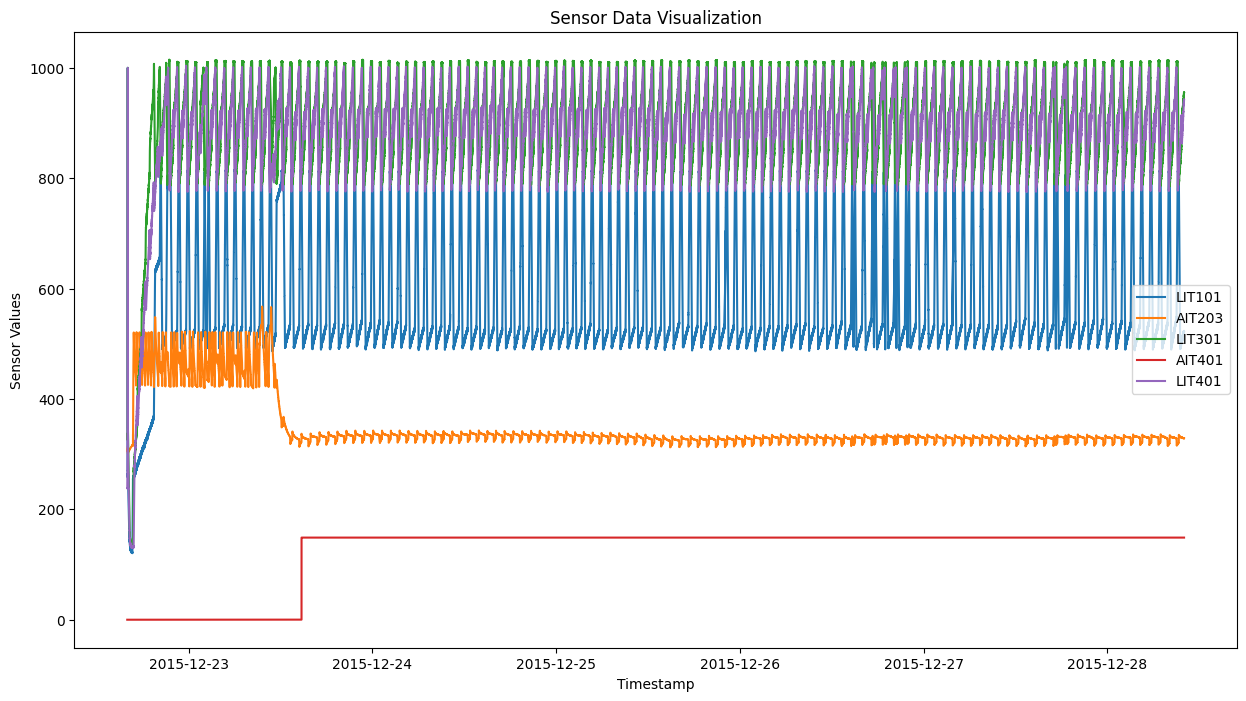

In [5]:
high_variance, mean_around_zero, constant_signal = [], [], []      # Arrays to store column names
for column in train_data:
    if column == 'Timestamp' or column == 'Normal/Attack':          # Ignore timestamps and labels
        continue
    variance = np.var(train_data[column])                           # Compute the variance
    mean = np.mean(train_data[column])                              # Compute the mean

    if variance > 1000:                                             # High variance
        high_variance.append(column)
    if variance == 0:                                               # Variance is equal to 0 (the signal is constant)
        constant_signal.append(column)
    if mean < 2 and variance != 0:                                  # Mean close to 0 and the signal is not constant
        mean_around_zero.append(column)

visualize_sensor_data(train_data, sensors=high_variance)

The second type of signals is a constant signal, this behaviour can be observed by looking at signals that have a variance equal to 0. We can see them as a straight line on the plot below:

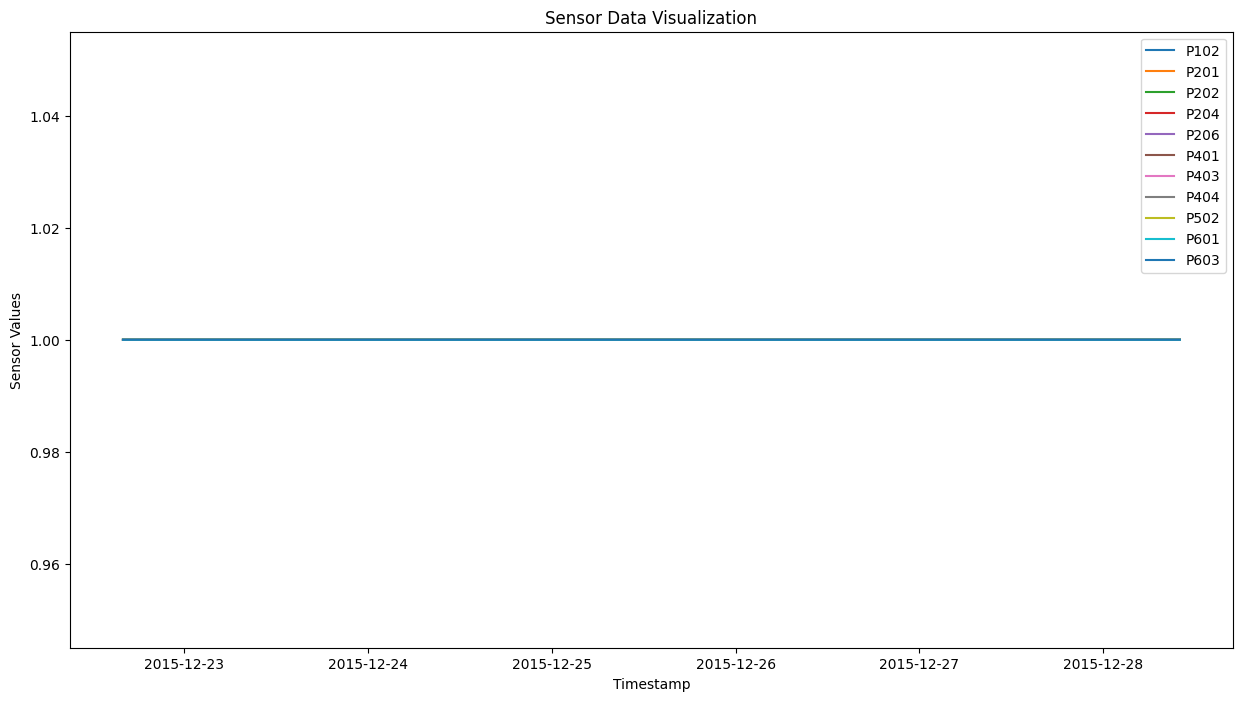

In [6]:
visualize_sensor_data(train_data, sensors=constant_signal)

The third type of signals in our dataset have a mean close to zero (less than 2 in our case). These signals are displayed below:

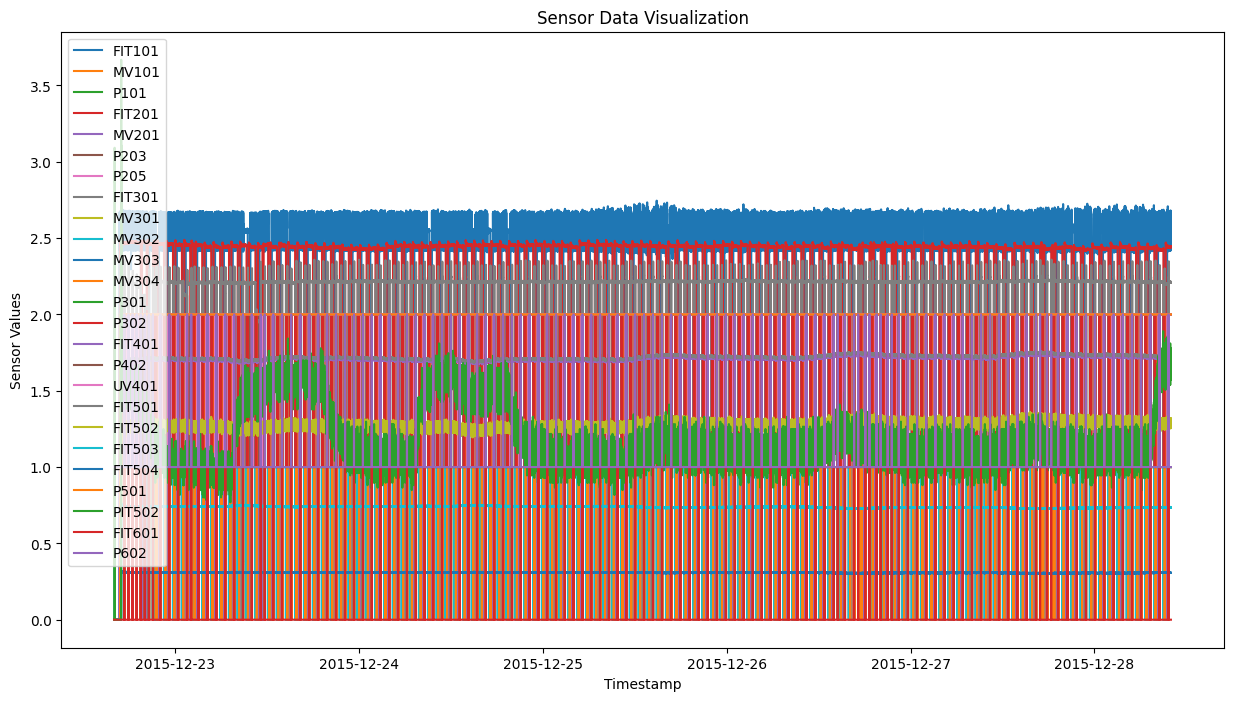

In [7]:
visualize_sensor_data(train_data, sensors=mean_around_zero)

To test for correlation we can create a Heatmap and observe which sensors are correlated based on the color. If the color is red, there is a positive correlation between two sensors, which means if one value increases, the other one also increases proportionally. If, on the other hand, the color is blue, then the correlation is negative and when one value increases the other one decreases proportionally. If the color is white, there is no correlation.

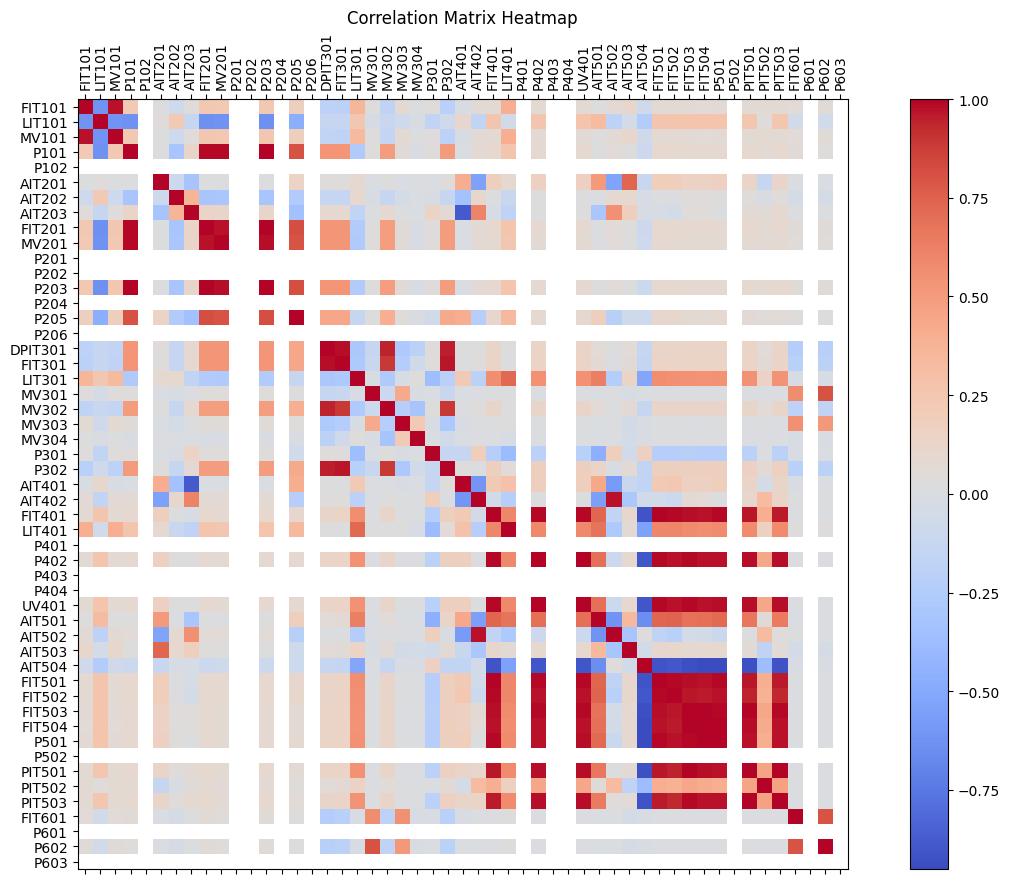

In [8]:
visualization_data = train_data.drop(columns=['Timestamp', 'Normal/Attack'], errors='ignore')   # Drop non-numeric columns
correlation_matrix = visualization_data.corr()                                                  # Compute the correlation matrix

# Create a Heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(16, 10))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.columns)
plt.xticks(rotation=90)
plt.title('Correlation Matrix Heatmap')

plt.show()

### Dynamic Time Warping

Implement the dynamic_time_warping() subroutine in the provided code base. This function takes as input two vectors of floating-point numbers and returns a floating-point number – the computed distance – as output.

Use Euclidean distance as a distance metric.

In [9]:
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (a[i - 1] - b[j - 1]) * (a[i - 1] - b[j - 1])
            dtw_matrix[i, j] = cost + max(0, min(dtw_matrix[i - 1, j],      # insertion
                                          dtw_matrix[i, j - 1],             # deletion
                                          dtw_matrix[i - 1, j - 1]))        # match

    # DTW distance = value of bottom-right position
    dtw_distance = np.sqrt(dtw_matrix[n, m])

    return dtw_distance

### DTW-Based Anomaly Detection

Choose one signal that displays interesting temporal behavior. Build a set of representative sliding windows from the training data. This can be all data points, but to lower the run-time you can consider taking a subset. Plot the distances (sometimes called residual) of the train and test data points of this signal to their closest representative window (excluding overlapping ones). What kind of anomalies do you expect to detect using DTW distances in this manner? Experiment with using different sliding window sizes and jumps (sometimes called stride). Set these in such a way that you expect to detect anomalies with a low number of false alarms and such that the run-time is not too large. Show your analysis and explain your expectation.

#### Prepare the data for DTW

In [10]:
test_file_path = 'lab1_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',') # Test data
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p') # Convert from Timestamp to d/m/y format

df_train = train_data
df_test = test_data

labels = df_train['Normal/Attack']                     # Create labels array
df_train = df_train.drop(columns=['Normal/Attack'])    # Remove not needed columns
df_test = df_test.drop(columns=['Normal/Attack'])      # Remove not needed columns

#### Plot the Distances to Closest Window

We expect to find contextual anomalies. We have chosen the signal LIT101 because it has the highest variance, as seen in the **Familiarization** part of the assignment. We have also chosen a window of size 50 and a stride of size 1000 - any larger and the graph would have too few data points, any smaller and the run-time would be too large. With these settings, we can detect anomalies with a low number of false alarms.

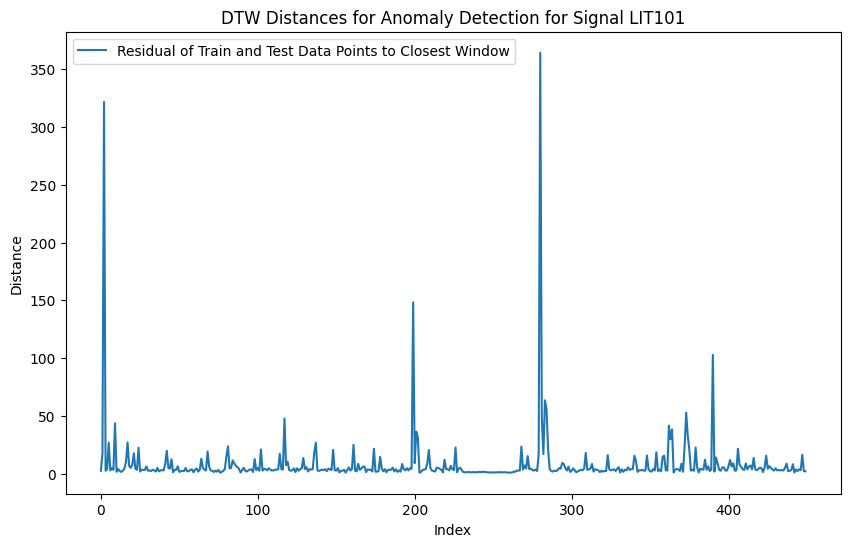

In [11]:
# Choose signal LIT101

# Build sliding windows for the chosen signal
w_train = np.lib.stride_tricks.sliding_window_view(df_train['LIT101'], 50)[::1000, :]
w_test = np.lib.stride_tricks.sliding_window_view(df_test['LIT101'], 50)[::1000, :]

# Calculate DTW distances for each test data point to the closest training window
dist = []
for test in w_test:
    minn = np.inf
    for train in w_train:
        d = dynamic_time_warping(train, test)
        if minn > d:
            minn = d

    # Append minimal distance obtained using DTW
    dist.append(minn)

# Plot distances
plt.figure(figsize=(10, 6))
plt.plot(dist, label='Residual of Train and Test Data Points to Closest Window')

plt.xlabel('Index')
plt.ylabel('Distance')
plt.legend()

plt.title('DTW Distances for Anomaly Detection for Signal LIT101')
plt.show()

As we can clearly see, there are a number of anomalies present. Since for contextual anomalies, we expect that the next data point is always close to the previous point and we raise an alarm if the distance between the two is too great, the anomalies we can observe seem to be of this type. After analyzing the result, we can choose to label a data point with distance > 50 as an anomaly. Then, we remove them from the data set. This is the final result:

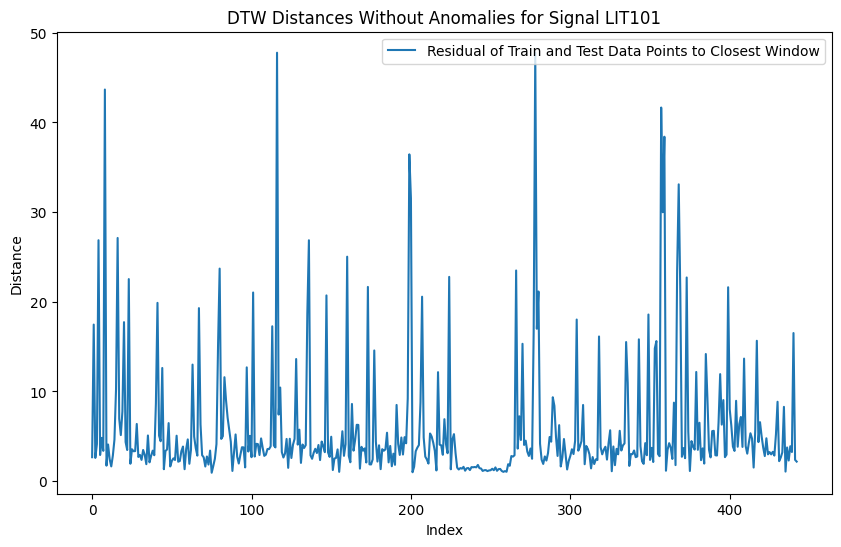

In [13]:
dist = []
threshold = 50     # Set the value for the threshold
for test in w_test:
    minn = np.inf
    for train in w_train:
        d = dynamic_time_warping(train, test)
        if minn > d:
            minn = d

    # Check if the data point is an anomaly
    if minn <= threshold:
        dist.append(minn)
    
# Plot distances
plt.figure(figsize=(10, 6))
plt.plot(dist, label='Residual of Train and Test Data Points to Closest Window')

plt.xlabel('Index')
plt.ylabel('Distance')
plt.legend()

plt.title('DTW Distances Without Anomalies for Signal LIT101')
plt.show()

### PCA

Implement the principal_component_analysis() and apply_principal_component_analysis() subroutines in the provided code base. The principal_component_analysis() function takes as input a data frame and an integer that denotes the number of required eigenvalues. It should return the eigenvectors it computed from the dataframe. The apply_principal_component_analysis() function takes as input a data frame and a list of eigenvectors. It should return the reduced data frame after applying principal component analysis to the provided data frame.

In [14]:
def principal_component_analysis(df, k):
    cov_matrix = np.cov(df, rowvar=False)                           # create the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)           # compute eigen vectors/values
    indexes = np.argsort(eigenvalues)[::-1]                         # sort eigenvalues in descending order and return their indexes
    eigenvectors = eigenvectors[:, indexes]                         # reorder columns of eigenvectors based on the indexes
    return eigenvectors[:, :k]                                      # return only the required eigenvalues


def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.dot(df - df.mean(axis=0), eigenvectors)     # appy PCA
    return pd.DataFrame(projected_data)                             # return a new DataFrame

### PCA-Based Anomaly Detection

Perform PCA-based anomaly detection on the signal multivariate data points (do not take sequential context into account). You compute PCA to the train data, and apply it to both the train and test data. Plot the distance (residual, your choice of distance function) between the original and reconstructed data points. Do you see large abnormalities in the training data? Can you explain why these occur? It is best to remove such abnormalities from the training data since you only want to model normal behavior. Describe the kind of anomalies you expect to detect using PCA.
Plot the PCA residuals for different number of components on the training data as one signal. Choose the number of components based on the residuals and detected anomalies. Aim to set it such that you expect a small number of false alarms while still able to detect anomalies. Show your analysis and explain your expectation.

#### Prepare the data for PCA

In [15]:
test_file_path = 'lab1_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')              # Test data

df_train = train_data
df_test = test_data
labels = df_train['Normal/Attack']                                  # Create labels array
df_train = df_train.drop(columns=['Timestamp', 'Normal/Attack'])    # Remove not needed columns
df_test = df_test.drop(columns=['Timestamp', 'Normal/Attack'])      # Remove not needed columns

#### Compute PCA and Plot Distances

We compute PCA to the train data, and apply it both to train and test data. Then, we plot the distances between original and the reconstructed data points. We expect to find point anomalies.

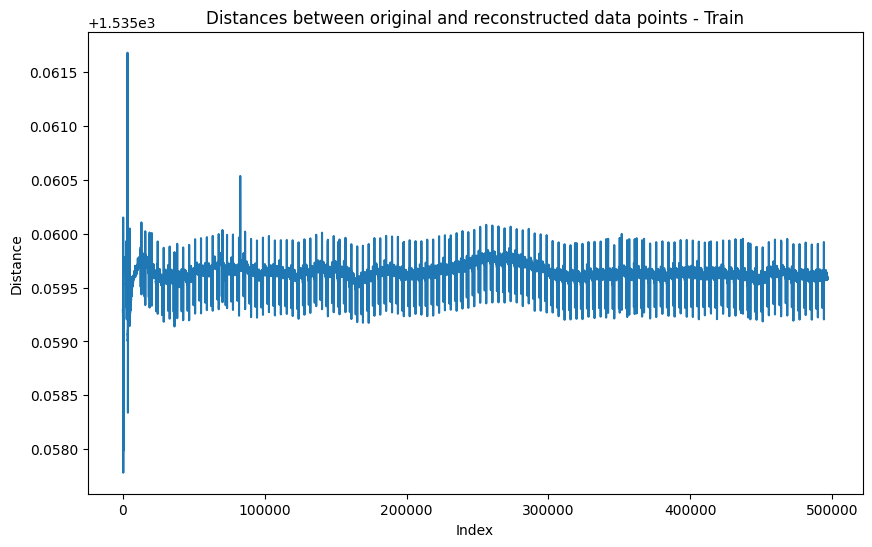

In [16]:
vectors = principal_component_analysis(df_train, 30)                        # Eigenvectors
transformed_train = apply_principal_component_analysis(df_train, vectors)   # Apply PCA on train data
reconstructed_train = np.dot(transformed_train, vectors.T)                  # Reconstruct the train data
distances = np.linalg.norm(df_train - reconstructed_train, axis=1)          # Compute distance

# Plot the distances for training set
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Distances between original and reconstructed data points - Train')
plt.show()

There seems to be a large difference in the distance for the datapoints at the very beginning, so we can get rid of the anomalies.

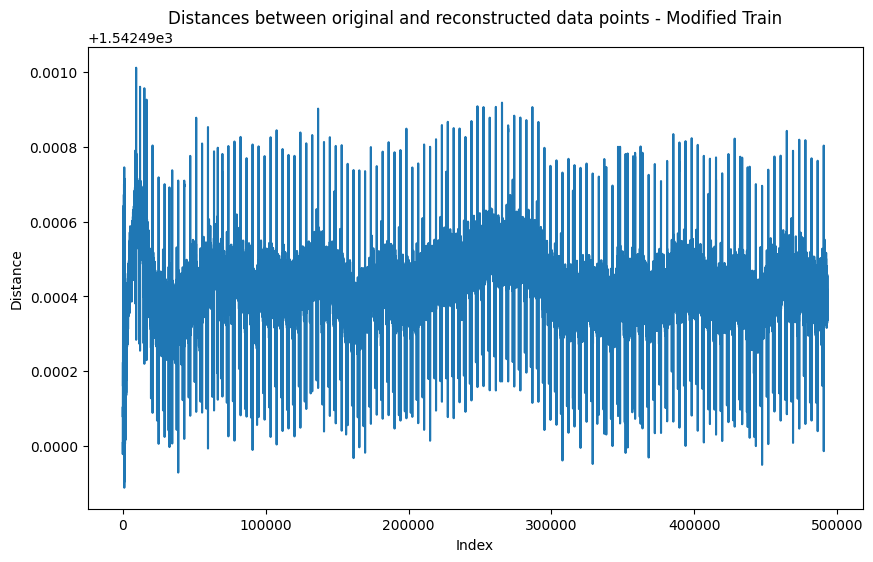

In [17]:
# Find the large outliers
abnormalities = np.where((distances - 1535 > 0.0605) | (distances - 1535 < 0.0590))

# Retrain with the modified data
modified_train = df_train.iloc[list(range(3700, 82750)) + list(range(82770, len(df_train)))]
vectors = principal_component_analysis(modified_train, 30)
transformed_train = apply_principal_component_analysis(modified_train, vectors)
reconstructed_train = np.dot(transformed_train, vectors.T)
distances = np.linalg.norm(modified_train - reconstructed_train, axis=1)

# Plot the distances for the new training set
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Distances between original and reconstructed data points - Modified Train')
plt.show()

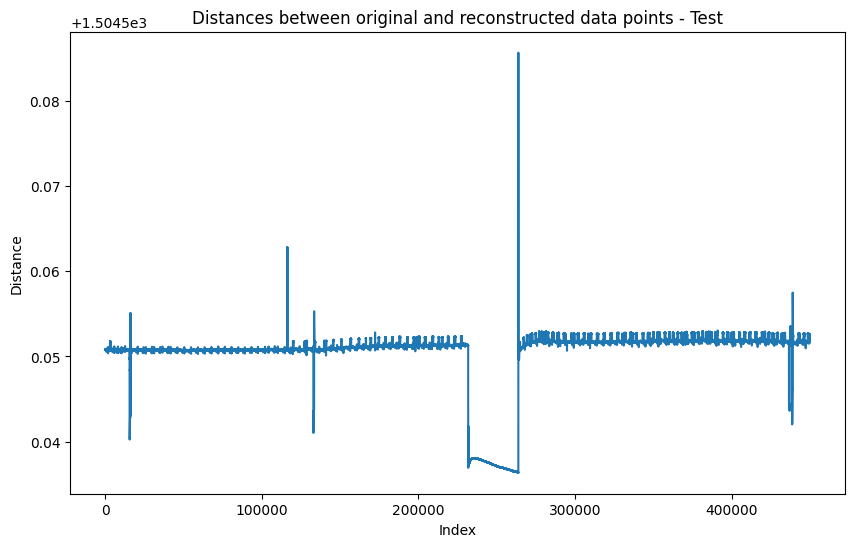

In [18]:
transformed_test = apply_principal_component_analysis(df_test, vectors)   # Apply PCA on test data
reconstructed_test = np.dot(transformed_test, vectors.T)                  # Reconstruct the test data
distances = np.linalg.norm(df_test - reconstructed_test, axis=1)          # Compute Euclidean distance

# Plot the distances for training set
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Distances between original and reconstructed data points - Test')
plt.show()